# The harmonic function method and the mass of some Schwarzschild half-spaces - Computations and Graphs

In this Jupyter Notebook, we will do two main things for our examples from Section 8:
- Compute the lower bound given by Theorem 3.9
- Plot the level sets of the harmonic coordinates

### Setting up the Python environment

In [1]:
# This file is present both as .ipynb as well as .py. For the latter, the `# %%` comment denote borders between cells so the Python file can be treated like an Jupyter notebook as well. The function below checks if the Python file is running inside a Jupyter Notebook
def is_notebook() -> bool:
  try:
    shell = get_ipython().__class__.__name__ # type: ignore[reportUndefinedVariable]
    if shell in ('ZMQInteractiveShell','XPythonShell'):
        return True   # Jupyter notebook or qtconsole
    elif shell == 'TerminalInteractiveShell':
        return False  # Terminal running IPython
    else:
        return False  # Other type (?)
  except NameError:
    return False      # Probably standard Python interpreter

In [2]:
# if is_notebook():
#   get_ipython().run_line_magic("pip", "install gravipy matplotlib scikit-image") # this helps if this Notebook is executed from within e.g. jupyter-cloud.gwdg.de  # type: ignore[reportUndefinedVariable]

In [3]:
from gravipy.tensorial import * # import GraviPy package
import sympy
import numpy as np
import scipy
import matplotlib.pyplot as plt

# for plotting of implicit surfaces (i.e. the level sets)
from mpl_toolkits.mplot3d import axes3d
from skimage import measure

from sympy.utilities.lambdify import lambdastr

In [4]:
if is_notebook():
  from IPython.display import display, Markdown
else:
  from rich.markdown import Markdown
  from rich.console import Console
  console = Console()
  display = console.print


### Setting up the manifold, metric, etc.

In [5]:
dim = 3

non_bounded_coords_string = " ".join(f"x_{i}" for i in range(2,dim+1))
non_bounded_coords = list(symbols(non_bounded_coords_string, real=True))
x1 = symbols("x_1", nonnegative=True)
m = symbols("m",positive=True)
r_critical = symbols(r"\tilde{r}",positive=True) 
# r_critical = (m/2)**(1/(dim-2))

 
coords=[x1]+non_bounded_coords
pos = Coordinates(r'\chi',coords)
R=sympy.sqrt(sum(xi**2 for xi in coords))
omega=(1+(r_critical/R)**(dim-2))
exponent=4/(dim-2)
# metric = sympy.MatrixSymbol("g",3,3)
metric = omega**exponent*sympy.eye(dim)
g = MetricTensor('g', pos, metric)
Ga = Christoffel(r'\Gamma', g)

In [6]:
# useful for all kinds of integrals
volume_element = sympy.sqrt(sympy.Determinant(metric)).simplify()
hypersurface_volume_element = sympy.sqrt(sympy.Determinant(metric[1:,1:])).simplify()

In [7]:
# metric of hypersurface
gamma_metric = omega**exponent*sympy.diag(*([0]+[1]*(dim-1)))
gamma = MetricTensor(r'\gamma', pos, gamma_metric)
Ga_gamma = Christoffel(r'\Gamma_{\gamma}',gamma)

Some utility functions:

In [8]:
def laplacian(scalar):
  return sum([g(-i,-j)*scalar.covariantD(i,j) for i in range(1,dim+1) for j in range(1,dim+1)])

In [9]:
def gradient(symbol):
  V = Tensor(r"\Nabla "+str(symbol),1,g)
  def compute_V(idxs):
    component=sympy.diff(symbol,coords[idxs[0]-1])
    V.components.update({idxs:component})
    return component
  V._compute_contravariant_component=compute_V
  return V

### Setting up the harmonic coordinates

Define all the harmonic coordinates for $M_{m,+}$:

In [10]:
u1,*non_bounded_u = [Tensor(f"u_{i}",0,g) for i in range(1,dim+1)]
harmonic_coords = [u1]+non_bounded_u

def make_u_method(x,u):
  def u_method(idxs):
    component = x*(1+(r_critical/R)**dim)/omega
    u.components.update({idxs: component})
    return component
  return u_method

for x, u in zip(coords,harmonic_coords):
  u._compute_covariant_component = make_u_method(x,u)

And define $u_1$ for the modified Schwarzschild space $M_{m,\geq a}$ for $a>0$:

In [11]:
a = symbols("a")
u1_modified = Tensor("u_1",0,g)

def u1_modified_method(idxs):
    component = (x1+a*(r_critical/R)**(dim-2))/omega
    u1_modified.components.update({idxs: component})
    return component
u1_modified._compute_covariant_component = u1_modified_method

## Testing our Setup

### What's the mass of our space?

We use the spherical symmetry of the solution to avoid the integral, but we do evaluate the integrand in one radial direction (namely along the $x_1$-axis)

In [12]:
normal_vector_to_sphere = Tensor(r"n_{S_r}",1,g)
def n_S_r_compute_covariant_component(idxs):
  component = sympy.sqrt(g(idxs[0],idxs[0]))*coords[idxs[0]-1]/R
  normal_vector_to_sphere.components.update({idxs:component})
  return component
normal_vector_to_sphere._compute_covariant_component=n_S_r_compute_covariant_component

In [13]:
normal_vector_to_sphere(1)

x_1*sqrt((\tilde{r}/sqrt(x_1**2 + x_2**2 + x_3**2) + 1)**4.0)/sqrt(x_1**2 + x_2**2 + x_3**2)

In [14]:
mass_integrand = sum((g.partialD(i,j,i)-g.partialD(i,i,j))*normal_vector_to_sphere(-j) for i,j in list(variations(range(1,dim+1),2,True)))
ray_substition = list([coord,0] for coord in non_bounded_coords)
ray_mass_integrand = mass_integrand.subs(ray_substition).simplify()

In [15]:
ray_mass_integrand

8.0*\tilde{r}*(\tilde{r} + x_1)**1.0/x_1**3.0

Here and in the following we will need the area of an $(n-1)$-sphere

In [16]:
sphere_volume = sympy.pi ** (sympy.Number(dim) / 2) / sympy.gamma(sympy.Number(dim) / 2 + 1)
normalization = 1 / (sphere_volume * 2 * (dim - 1))
numerical_normalization = float(normalization)

In [17]:
unnormalized_mass_integral = (ray_mass_integrand*(hypersurface_volume_element*sphere_volume*R**(dim-1)).subs(ray_substition)).simplify()
unnormalized_mass = sympy.Limit(unnormalized_mass_integral,x1,sympy.oo).simplify()
mass = normalization*unnormalized_mass

The following should return $m=2\tilde{r}^{n-2}$, where $n$ is the dimension.

In [18]:
display(Markdown(f"The mass is ${sympy.latex(mass)}$"))
assert(mass==(2*r_critical**(dim-2)).simplify())

The mass is $2 \tilde{r}$

### Is the mean curvature correct?

We compute the mean curvature of the noncompact boundary (observe that the result agrees with our computation in Section 8)

In [19]:
normal_vector_to_noncompact_boundary = Tensor(r"\nu",1,g) 
def nu_compute_covariant_component(idxs):   
  if idxs[0]==1:     
    component = -sympy.sqrt(g(1,1))   
  else:
     component = sympy.Number(0)   
  normal_vector_to_noncompact_boundary.components.update({idxs:component})  
  return component 
normal_vector_to_noncompact_boundary._compute_covariant_component=nu_compute_covariant_component

In [20]:
H=sum(g(-i,-j)*normal_vector_to_noncompact_boundary.covariantD(i,j) for i,j in variations(range(1,dim+1),2,True)).simplify()
display(Markdown(f"Mean curvature $H$ of non-compact boundary is ${sympy.latex(H)}$, which is the same as $\\frac{{2 (n-1)\\tilde{{r}}^{{n-2}}}}{{r^n\\cdot \omega^{{2/(n-2)+1}}}}x_1={sympy.latex((2*(dim-1)*r_critical**(dim-2)*x1/(R**dim*omega**(2/(dim-2)+1))).simplify())}$."))
assert((H-2*(dim-1)*r_critical**(dim-2)*x1/(R**dim*omega**(2/(dim-2)+1))).simplify()==0)

Mean curvature $H$ of non-compact boundary is $\frac{4.0 \tilde{r} x_{1}}{\left(\tilde{r} + \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}}\right)^{3.0}}$, which is the same as $\frac{2 (n-1)\tilde{r}^{n-2}}{r^n\cdot \omega^{2/(n-2)+1}}x_1=\frac{4 \tilde{r} x_{1}}{\left(\tilde{r} + \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}}\right)^{3.0}}$.


The above is greater than $0$ in particular if $x_1>0$.

### Are our functions truly harmonic?

In [22]:
u1()

x_1*(\tilde{r}**3/(x_1**2 + x_2**2 + x_3**2)**(3/2) + 1)/(\tilde{r}/sqrt(x_1**2 + x_2**2 + x_3**2) + 1)

In [21]:
print("Harmonicity check:")
for i,u in enumerate(harmonic_coords):
  current_laplacian = laplacian(u).simplify()
  display(Markdown(f"$\Delta u_{i+1}={sympy.latex(current_laplacian)}$"))
  # assert(current_laplacian==0)

Harmonicity check:


$\Delta u_1=\frac{1.0 \tilde{r} x_{1} \cdot \left(2.0 \tilde{r}^{4} x_{1}^{6} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 2.0 \tilde{r}^{4} x_{1}^{4} x_{2}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 2.0 \tilde{r}^{4} x_{1}^{4} x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 10.0 \tilde{r}^{4} x_{1}^{2} x_{2}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 20.0 \tilde{r}^{4} x_{1}^{2} x_{2}^{2} x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 10.0 \tilde{r}^{4} x_{1}^{2} x_{3}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 2.0 \tilde{r}^{4} x_{1}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{2.5} - 6.0 \tilde{r}^{4} x_{2}^{6} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 18.0 \tilde{r}^{4} x_{2}^{4} x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 18.0 \tilde{r}^{4} x_{2}^{2} x_{3}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 6.0 \tilde{r}^{4} x_{2}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{2.5} - 6.0 \tilde{r}^{4} x_{3}^{6} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 6.0 \tilde{r}^{4} x_{3}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{2.5} + 4.0 \tilde{r}^{3} x_{1}^{8} + 4.0 \tilde{r}^{3} x_{1}^{6} x_{2}^{2} + 4.0 \tilde{r}^{3} x_{1}^{6} x_{3}^{2} - 12.0 \tilde{r}^{3} x_{1}^{4} x_{2}^{4} - 24.0 \tilde{r}^{3} x_{1}^{4} x_{2}^{2} x_{3}^{2} - 12.0 \tilde{r}^{3} x_{1}^{4} x_{3}^{4} - 20.0 \tilde{r}^{3} x_{1}^{2} x_{2}^{6} - 60.0 \tilde{r}^{3} x_{1}^{2} x_{2}^{4} x_{3}^{2} - 60.0 \tilde{r}^{3} x_{1}^{2} x_{2}^{2} x_{3}^{4} - 20.0 \tilde{r}^{3} x_{1}^{2} x_{3}^{6} - 4.0 \tilde{r}^{3} x_{1}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.0} - 8.0 \tilde{r}^{3} x_{2}^{8} - 32.0 \tilde{r}^{3} x_{2}^{6} x_{3}^{2} - 48.0 \tilde{r}^{3} x_{2}^{4} x_{3}^{4} - 32.0 \tilde{r}^{3} x_{2}^{2} x_{3}^{6} + 8.0 \tilde{r}^{3} x_{2}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.0} - 8.0 \tilde{r}^{3} x_{3}^{8} + 8.0 \tilde{r}^{3} x_{3}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.0} - 4.0 \tilde{r} x_{1}^{10} - 16.0 \tilde{r} x_{1}^{8} x_{2}^{2} - 16.0 \tilde{r} x_{1}^{8} x_{3}^{2} - 24.0 \tilde{r} x_{1}^{6} x_{2}^{4} - 48.0 \tilde{r} x_{1}^{6} x_{2}^{2} x_{3}^{2} - 24.0 \tilde{r} x_{1}^{6} x_{3}^{4} - 16.0 \tilde{r} x_{1}^{4} x_{2}^{6} - 48.0 \tilde{r} x_{1}^{4} x_{2}^{4} x_{3}^{2} - 48.0 \tilde{r} x_{1}^{4} x_{2}^{2} x_{3}^{4} - 16.0 \tilde{r} x_{1}^{4} x_{3}^{6} + 4.0 \tilde{r} x_{1}^{4} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.0} - 4.0 \tilde{r} x_{1}^{2} x_{2}^{8} - 16.0 \tilde{r} x_{1}^{2} x_{2}^{6} x_{3}^{2} - 24.0 \tilde{r} x_{1}^{2} x_{2}^{4} x_{3}^{4} - 16.0 \tilde{r} x_{1}^{2} x_{2}^{2} x_{3}^{6} + 4.0 \tilde{r} x_{1}^{2} x_{2}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.0} - 4.0 \tilde{r} x_{1}^{2} x_{3}^{8} + 4.0 \tilde{r} x_{1}^{2} x_{3}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.0} - 2.0 x_{1}^{10} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 10.0 x_{1}^{8} x_{2}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 10.0 x_{1}^{8} x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 20.0 x_{1}^{6} x_{2}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 40.0 x_{1}^{6} x_{2}^{2} x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 20.0 x_{1}^{6} x_{3}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 20.0 x_{1}^{4} x_{2}^{6} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 60.0 x_{1}^{4} x_{2}^{4} x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 60.0 x_{1}^{4} x_{2}^{2} x_{3}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 20.0 x_{1}^{4} x_{3}^{6} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 2.0 x_{1}^{4} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.5} - 10.0 x_{1}^{2} x_{2}^{8} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 40.0 x_{1}^{2} x_{2}^{6} x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 60.0 x_{1}^{2} x_{2}^{4} x_{3}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 40.0 x_{1}^{2} x_{2}^{2} x_{3}^{6} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 4.0 x_{1}^{2} x_{2}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.5} - 10.0 x_{1}^{2} x_{3}^{8} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 4.0 x_{1}^{2} x_{3}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.5} - 2.0 x_{2}^{10} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 10.0 x_{2}^{8} x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 20.0 x_{2}^{6} x_{3}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 20.0 x_{2}^{4} x_{3}^{6} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 2.0 x_{2}^{4} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.5} - 10.0 x_{2}^{2} x_{3}^{8} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 4.0 x_{2}^{2} x_{3}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.5} - 2.0 x_{3}^{10} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 2.0 x_{3}^{4} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.5}\right)}{\left(\tilde{r} + \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}}\right)^{7.0} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.5}}$

$\Delta u_2=\frac{1.0 \tilde{r} x_{2} \left(- 6.0 \tilde{r}^{4} x_{1}^{6} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 10.0 \tilde{r}^{4} x_{1}^{4} x_{2}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 18.0 \tilde{r}^{4} x_{1}^{4} x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 2.0 \tilde{r}^{4} x_{1}^{2} x_{2}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 20.0 \tilde{r}^{4} x_{1}^{2} x_{2}^{2} x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 18.0 \tilde{r}^{4} x_{1}^{2} x_{3}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 6.0 \tilde{r}^{4} x_{1}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{2.5} + 2.0 \tilde{r}^{4} x_{2}^{6} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 2.0 \tilde{r}^{4} x_{2}^{4} x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 10.0 \tilde{r}^{4} x_{2}^{2} x_{3}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 2.0 \tilde{r}^{4} x_{2}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{2.5} - 6.0 \tilde{r}^{4} x_{3}^{6} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 6.0 \tilde{r}^{4} x_{3}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{2.5} - 8.0 \tilde{r}^{3} x_{1}^{8} - 20.0 \tilde{r}^{3} x_{1}^{6} x_{2}^{2} - 32.0 \tilde{r}^{3} x_{1}^{6} x_{3}^{2} - 12.0 \tilde{r}^{3} x_{1}^{4} x_{2}^{4} - 60.0 \tilde{r}^{3} x_{1}^{4} x_{2}^{2} x_{3}^{2} - 48.0 \tilde{r}^{3} x_{1}^{4} x_{3}^{4} + 4.0 \tilde{r}^{3} x_{1}^{2} x_{2}^{6} - 24.0 \tilde{r}^{3} x_{1}^{2} x_{2}^{4} x_{3}^{2} - 60.0 \tilde{r}^{3} x_{1}^{2} x_{2}^{2} x_{3}^{4} - 32.0 \tilde{r}^{3} x_{1}^{2} x_{3}^{6} + 8.0 \tilde{r}^{3} x_{1}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.0} + 4.0 \tilde{r}^{3} x_{2}^{8} + 4.0 \tilde{r}^{3} x_{2}^{6} x_{3}^{2} - 12.0 \tilde{r}^{3} x_{2}^{4} x_{3}^{4} - 20.0 \tilde{r}^{3} x_{2}^{2} x_{3}^{6} - 4.0 \tilde{r}^{3} x_{2}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.0} - 8.0 \tilde{r}^{3} x_{3}^{8} + 8.0 \tilde{r}^{3} x_{3}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.0} - 4.0 \tilde{r} x_{1}^{8} x_{2}^{2} - 16.0 \tilde{r} x_{1}^{6} x_{2}^{4} - 16.0 \tilde{r} x_{1}^{6} x_{2}^{2} x_{3}^{2} - 24.0 \tilde{r} x_{1}^{4} x_{2}^{6} - 48.0 \tilde{r} x_{1}^{4} x_{2}^{4} x_{3}^{2} - 24.0 \tilde{r} x_{1}^{4} x_{2}^{2} x_{3}^{4} - 16.0 \tilde{r} x_{1}^{2} x_{2}^{8} - 48.0 \tilde{r} x_{1}^{2} x_{2}^{6} x_{3}^{2} - 48.0 \tilde{r} x_{1}^{2} x_{2}^{4} x_{3}^{4} - 16.0 \tilde{r} x_{1}^{2} x_{2}^{2} x_{3}^{6} + 4.0 \tilde{r} x_{1}^{2} x_{2}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.0} - 4.0 \tilde{r} x_{2}^{10} - 16.0 \tilde{r} x_{2}^{8} x_{3}^{2} - 24.0 \tilde{r} x_{2}^{6} x_{3}^{4} - 16.0 \tilde{r} x_{2}^{4} x_{3}^{6} + 4.0 \tilde{r} x_{2}^{4} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.0} - 4.0 \tilde{r} x_{2}^{2} x_{3}^{8} + 4.0 \tilde{r} x_{2}^{2} x_{3}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.0} - 2.0 x_{1}^{10} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 10.0 x_{1}^{8} x_{2}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 10.0 x_{1}^{8} x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 20.0 x_{1}^{6} x_{2}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 40.0 x_{1}^{6} x_{2}^{2} x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 20.0 x_{1}^{6} x_{3}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 20.0 x_{1}^{4} x_{2}^{6} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 60.0 x_{1}^{4} x_{2}^{4} x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 60.0 x_{1}^{4} x_{2}^{2} x_{3}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 20.0 x_{1}^{4} x_{3}^{6} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 2.0 x_{1}^{4} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.5} - 10.0 x_{1}^{2} x_{2}^{8} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 40.0 x_{1}^{2} x_{2}^{6} x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 60.0 x_{1}^{2} x_{2}^{4} x_{3}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 40.0 x_{1}^{2} x_{2}^{2} x_{3}^{6} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 4.0 x_{1}^{2} x_{2}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.5} - 10.0 x_{1}^{2} x_{3}^{8} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 4.0 x_{1}^{2} x_{3}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.5} - 2.0 x_{2}^{10} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 10.0 x_{2}^{8} x_{3}^{2} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 20.0 x_{2}^{6} x_{3}^{4} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} - 20.0 x_{2}^{4} x_{3}^{6} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 2.0 x_{2}^{4} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.5} - 10.0 x_{2}^{2} x_{3}^{8} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 4.0 x_{2}^{2} x_{3}^{2} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.5} - 2.0 x_{3}^{10} \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}} + 2.0 x_{3}^{4} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.5}\right)}{\left(\tilde{r} + \sqrt{x_{1}^{2} + x_{2}^{2} + x_{3}^{2}}\right)^{7.0} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2}\right)^{3.5}}$

KeyboardInterrupt: 

In [ ]:
laplacian_modified = laplacian(u1_modified).simplify()
display(Markdown(f"For $M_{{m,\geq a}}$: $\Delta u_1={laplacian_modified}$"))
assert(laplacian_modified == 0)

For $M_{m,\geq a}$: $\Delta u_1=0$

### Are the boundary conditions truly fulfilled?

For $a=0$ we should in particular have $\partial_r u_i\vert_{r=\tilde{r}}=0$:

In [ ]:
for (i,u) in enumerate(harmonic_coords):
  radial_derivative = sum(u.covariantD(i+1)*coords[i] for i in range(dim))
  substitution = [x1,sympy.sqrt(r_critical**2-sum(coord**2 for coord in non_bounded_coords))]
  radial_derivative_substituted = radial_derivative.subs([substitution]).simplify()
  display(Markdown(f"$\partial_r u_{i+1}\\vert_{{r=\\tilde{{r}}}}={sympy.latex(radial_derivative_substituted)}$"))
  assert(radial_derivative_substituted==0)

$\partial_r u_1\vert_{r=\tilde{r}}=0$

$\partial_r u_2\vert_{r=\tilde{r}}=0$

$\partial_r u_3\vert_{r=\tilde{r}}=0$

$\partial_r u_4\vert_{r=\tilde{r}}=0$

For $a>0$, we should have $\tilde{u}_1\vert_{x_1=a}=a$:

In [ ]:
u1_modified_at_x1_equal_a=u1_modified().subs([[x1,a]]).simplify()
display(Markdown(f"$\\tilde{{u}}_1\\vert_{{x_1=a}}={u1_modified_at_x1_equal_a}$"))
assert(u1_modified_at_x1_equal_a==a)

$\tilde{u}_1\vert_{x_1=a}=a$

### Are there any critical points?

It is interesting to consider whether there are any critical points of $u_3$ to be able to discuss how strong the lower bound given by our technique is (see Remark 4.3).

##### For $M_{m,+}$ there is at least one (at (0,0,m/2)):

In [ ]:
display(
    Markdown(
        f"On $M_{{m,+}}$, there is at least one critical point: At $(0,0,\\tilde{{r}})$ we have $\operatorname{{grad}} u_1={sympy.latex(sympy.Array([u1.covariantD(i) for i in range(1,4)]).subs(([(x1,r_critical)]+list(map(lambda coord: (coord,0),non_bounded_coords)))).simplify())}$"
    )
)

On $M_{m,+}$, there is at least one critical point: At $(0,0,\tilde{r})$ we have $\operatorname{grad} u_1=\left[\begin{matrix}0 & 0 & 0\end{matrix}\right]$

##### For $M_{m,\geq a}$:

In [ ]:
relevant_derivative = u1_modified.covariantD(1).simplify()
only_numerator = sympy.fraction(relevant_derivative)[0].expand()
display(Markdown(f"""On $M_{{m,\geq a}} (for $a>0$), $u_1$ has no critical points! 
                 
It suffices to look at the derivative in $x_1$-direction, which is always positive: We have $\partial_1 u_1={sympy.latex(relevant_derivative)}$.

We can ignore the denominator (which is clearly always positive, since $|x|>0$) and just consider the numerator ${sympy.latex(only_numerator)}$.

But $x_1\geq a > 0$ and thus each of the {dim} negative terms in front are balanced out by later terms."""))

On $M_{m,\geq a} (for $a>0$), $u_1$ has no critical points! 
                 
It suffices to look at the derivative in $x_1$-direction, which is always positive: We have $\partial_1 u_1=\frac{2 \tilde{r}^{2} x_{1} \left(\tilde{r}^{2} a + x_{1} \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2}\right)\right) - \left(2 \tilde{r}^{2} a x_{1} - \left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2}\right)^{2}\right) \left(\tilde{r}^{2} + x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2}\right)}{\left(x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2}\right) \left(\tilde{r}^{2} + x_{1}^{2} + x_{2}^{2} + x_{3}^{2} + x_{4}^{2}\right)^{2}}$.

We can ignore the denominator (which is clearly always positive, since $|x|>0$) and just consider the numerator $- 2 \tilde{r}^{2} a x_{1}^{3} - 2 \tilde{r}^{2} a x_{1} x_{2}^{2} - 2 \tilde{r}^{2} a x_{1} x_{3}^{2} - 2 \tilde{r}^{2} a x_{1} x_{4}^{2} + 3 \tilde{r}^{2} x_{1}^{4} + 4 \tilde{r}^{2} x_{1}^{2} x_{2}^{2} + 4 \tilde{r}^{2} x_{1}^{2} x_{3}^{2} + 4 \tilde{r}^{2} x_{1}^{2} x_{4}^{2} + \tilde{r}^{2} x_{2}^{4} + 2 \tilde{r}^{2} x_{2}^{2} x_{3}^{2} + 2 \tilde{r}^{2} x_{2}^{2} x_{4}^{2} + \tilde{r}^{2} x_{3}^{4} + 2 \tilde{r}^{2} x_{3}^{2} x_{4}^{2} + \tilde{r}^{2} x_{4}^{4} + x_{1}^{6} + 3 x_{1}^{4} x_{2}^{2} + 3 x_{1}^{4} x_{3}^{2} + 3 x_{1}^{4} x_{4}^{2} + 3 x_{1}^{2} x_{2}^{4} + 6 x_{1}^{2} x_{2}^{2} x_{3}^{2} + 6 x_{1}^{2} x_{2}^{2} x_{4}^{2} + 3 x_{1}^{2} x_{3}^{4} + 6 x_{1}^{2} x_{3}^{2} x_{4}^{2} + 3 x_{1}^{2} x_{4}^{4} + x_{2}^{6} + 3 x_{2}^{4} x_{3}^{2} + 3 x_{2}^{4} x_{4}^{2} + 3 x_{2}^{2} x_{3}^{4} + 6 x_{2}^{2} x_{3}^{2} x_{4}^{2} + 3 x_{2}^{2} x_{4}^{4} + x_{3}^{6} + 3 x_{3}^{4} x_{4}^{2} + 3 x_{3}^{2} x_{4}^{4} + x_{4}^{6}$.

But $x_1\geq a > 0$ and thus each of the 4 negative terms in front are balanced out by later terms.

## Computation of the lower bound

Let's try to compute the lower bound for the mass. We avoid simplifying anything (I once tried to let `sympy` simplify `abs_hessian_u1`, and it did complete, but only after 10 hours!). Even with manual help factoring out $\omega$ terms and the like, the computation times are still often in the minutes. The numerical integration later on is fast enough to deal with unoptimized expressions.

In [ ]:
abs_nabla_u1=sympy.sqrt(sum(g(-i,-j)*u1.covariantD(i)*u1.covariantD(j) for i in range(1,dim+1) for j in range(1,dim+1)))

In [ ]:
abs_nabla_u1_modified=sympy.sqrt(sum(g(-i,-j)*u1_modified.covariantD(i)*u1_modified.covariantD(j) for i in range(1,dim+1) for j in range(1,dim+1)))

In [ ]:
abs_hessian_u1=sympy.sqrt(sum(g(-i,-k)*g(-j,-l)*u1.covariantD(i,j)*u1.covariantD(k,l) for i,j,k,l in list(variations(range(1, dim+1), 4, True))))

In [ ]:
abs_hessian_u1_modified=sympy.sqrt(sum(g(-i,-k)*g(-j,-l)*u1_modified.covariantD(i,j)*u1_modified.covariantD(k,l) for i,j,k,l in variations(range(1, dim+1), 4, True)))

We can now express the integrands. Note that we need to include the volume element. We will note down the necessary normalization factor here, but only use it later on. Also we have $R=0$, so the second term in the integrand disappears

In [ ]:
lower_bound_integrand_over_M=(abs_hessian_u1**2/abs_nabla_u1)*volume_element
lower_bound_modified_integrand_over_M=(abs_hessian_u1_modified**2/abs_nabla_u1_modified)*volume_element

We can now also write down the expression for integral term on the boundary (we need to use the volume element of $\Sigma$ here). Note that the integrand over the boundary vanishes for $M_{m,+}$.

In [ ]:
lower_bound_integrand_over_boundary = 2*(H.subs(x1,0).simplify()*abs_nabla_u1)*hypersurface_volume_element
print(f"{lower_bound_integrand_over_boundary=}")

lower_bound_modified_integrand_over_boundary = 2*(H.subs(x1,a).simplify()*abs_nabla_u1_modified)*hypersurface_volume_element

lower_bound_integrand_over_boundary=0


We use `sympy.lambdify` to get numerical expressions for our integrands. We set $m=2$(!) and $a=2$ for now.

In [ ]:
# numerical implementation (reverse args as we want x1 integration to be outermost)
num_lower_bound_integrand_over_M = sympy.lambdify(list(reversed(coords))+[r_critical],lower_bound_integrand_over_M)
num_lower_bound_integrand_over_boundary = sympy.lambdify(list(reversed(coords))+[r_critical],lower_bound_integrand_over_boundary)

num_lower_bound_modified_integrand_over_M = sympy.lambdify(
    list(reversed(coords)) + [r_critical,a], lower_bound_modified_integrand_over_M
)
num_lower_bound_modified_integrand_over_boundary = sympy.lambdify(
    list(reversed(coords)) + [r_critical, a], lower_bound_modified_integrand_over_boundary
)

We can now do the numerical integration. Due to symmetry we are able to only integrate over one quadrant ($x_2\geq 0, \dotsc, x_n\geq 0$ in addition to the usual $x_1\geq 0$) and multiply by $2^{n-1}$ afterwards.

In [ ]:
number_quadrants = 2**(dim-1)

def most_coords_range(*args):
  return [0,np.inf]
  
def xn_range(*args): 
  *previous_x_values,r_critical = args
  return [np.sqrt(max(sum(previous_x_value**2-r_critical**2 for previous_x_value in previous_x_values),0)),np.inf]


The integrand explodes near the intersection of the $x_1$-axis and the horizon, and thus convergence of the numerical integration is slow. To raise speed and lower accuracy, we can lower the `limit` parameter (for limiting the numbers of subintervals used in the algorithm). The default is 50 but takes forever, but already a value of 1 gives errors small enough for the result to be useful to us. With a limit of 2 the integration already takes three minutes on my machine and has only slightly better accuracy.

In [ ]:
r_critical_value=1 # corresponds to mass of 2, independent of dimension

result = scipy.integrate.nquad(
  func=num_lower_bound_integrand_over_M,
  ranges=[xn_range]+[most_coords_range]*(dim-1),
  args=[r_critical_value], # passed to all functions in addition to coordinates
  full_output=True,
  opts={"limit":1}
)

# we do not need to do the integral over the boundary here, since the integrand is 0

In [ ]:
schwarzschild_half_space_mass_lower_bound = normalization*2**(dim-1)*result[0]
error_estimate = normalization*2**(dim-1)*result[1]
number_evaluations = result[2]['neval']
m_value=2
display(Markdown(f"## Lower bound for mass (expected $m/2={m_value}/2={m_value/2}$) of $M_{{{m_value},+}}$ calculated in ${number_evaluations}$ evaluations as ${schwarzschild_half_space_mass_lower_bound:.5f}$ with an estimated absolute error of ${error_estimate:.5f}$."))

## Lower bound for mass (expected $m/2=2/2=1.0$) of $M_{2,+}$ calculated in $50625$ evaluations as $3.59163$ with an estimated absolute error of $2690.90425$.

We can now do the same process for $M_{m,\geq a}$ for $a>0$:

In [ ]:
modified_x1range=lambda r_critical_value,a_value:[a_value,np.inf]
def modified_non_bounded_coords_range(*args): 
  return [0,np.inf]

modified_non_bounded_coords_boundary_range = [0,np.inf]

a_value = 2


We have the same problem as before and need to limit the number of subintervals

In [ ]:
result_on_M = scipy.integrate.nquad(
  func=num_lower_bound_modified_integrand_over_M,
  ranges=[modified_non_bounded_coords_range]*(dim-1)+[modified_x1range],
  args=[r_critical_value,a_value],
  full_output=True,
  opts={"limit":1}
)

But on the boundary, the numerical integration converges nicely

In [ ]:
result_on_boundary = scipy.integrate.nquad(
  func=num_lower_bound_modified_integrand_over_boundary,
  ranges=[modified_non_bounded_coords_boundary_range]*(dim-1),
  args=[a_value,r_critical_value,a_value], # we also need to pass x_1=a here
  full_output=True,
  opts={"limit":2}
)

In [ ]:
result_on_M,result_on_boundary

((0.9664281198994181, 0.031988832243087455, {'neval': 50625}),
 (14.057664516668426, 1.1672665900334724, {'neval': 91125}))

In [ ]:
modified_schwarzschild_half_space_mass_lower_bound = normalization*number_quadrants*(result_on_M[0]+result_on_boundary[0])
error_estimate_modified = normalization*number_quadrants*(result_on_M[1]+result_on_boundary[1])
number_evaluations_modified = result_on_M[2]['neval'] + result_on_boundary[2]['neval'] # most of these will come from the boundary integral where we set the `limit` parameter higher
display(Markdown(f"## Lower bound for mass $m={m_value}$ of $M_{{m,\geq {a_value}}}$ calculated in ${number_evaluations_modified}$ evaluations as ${modified_schwarzschild_half_space_mass_lower_bound:.5f}$ with an estimated absolute error of ${error_estimate_modified:.5f}$."))

## Lower bound for mass $m=2$ of $M_{m,\geq 2}$ calculated in $141750$ evaluations as $4.05936$ with an estimated absolute error of $0.32403$.

We can repeat this calculation for different values of $a$ and plot the results:

In [ ]:
def calculate_lower_bound_modified(a_value,r_critical_value):
    result_on_M = scipy.integrate.nquad(
    func=num_lower_bound_modified_integrand_over_M,
    ranges=[modified_non_bounded_coords_range]*(dim-1)+[modified_x1range],
    args=[r_critical_value,a_value],
    full_output=True,
    opts={"limit":1}
  )
    result_on_boundary = scipy.integrate.nquad(
        func=num_lower_bound_modified_integrand_over_boundary,
        ranges=[modified_non_bounded_coords_boundary_range] * (dim - 1),
        args=[a_value, r_critical_value, a_value],  # we also need to pass x_1=a here
        full_output=True,
        opts={"limit": 1},
    )
    lower_bound_M = normalization*number_quadrants * result_on_M[0]
    lower_bound_boundary = normalization*number_quadrants * result_on_boundary[0]
    error_M = normalization*number_quadrants * result_on_M[1]
    error_boundary = normalization*number_quadrants * result_on_boundary[1]
    # number_evaluations_modified = result_on_M[2]['neval'] + result_on_boundary[2]['neval'] # most of these will come from the boundary integral where we set the `limit` parameter higher
    total_lower_bound = lower_bound_M + lower_bound_boundary
    total_error = error_M + error_boundary
    return [
        total_lower_bound,
        total_error,
        lower_bound_M,
        error_M,
        lower_bound_boundary,
        error_boundary,
    ]

# def print_lower_bound_modified_results(
#   modified_schwarzschild_half_space_mass_lower_bound,
#   error_estimate_modified,
#   number_evaluations_modified):
#   display(Markdown(f"## Lower bound for mass $m={m_value}$ of $M_{{m,\geq {a_value}}}$ calculated in ${number_evaluations}$ evaluations as ${modified_schwarzschild_half_space_mass_lower_bound:.5f}$ with an estimated absolute error of ${error_estimate:.5f}$."))

Computing the values for the plot might take a while

In [ ]:
a_values = np.array([1,2,5,10,100])
r_critical_value = 1
total_lower_bounds,total_errors,lower_bounds_M, errors_M, lower_bounds_boundary, errors_boundary = np.fromiter(
  (calculate_lower_bound_modified(a_value,m_value) for a_value in a_values),
  np.dtype((float,6))).transpose()

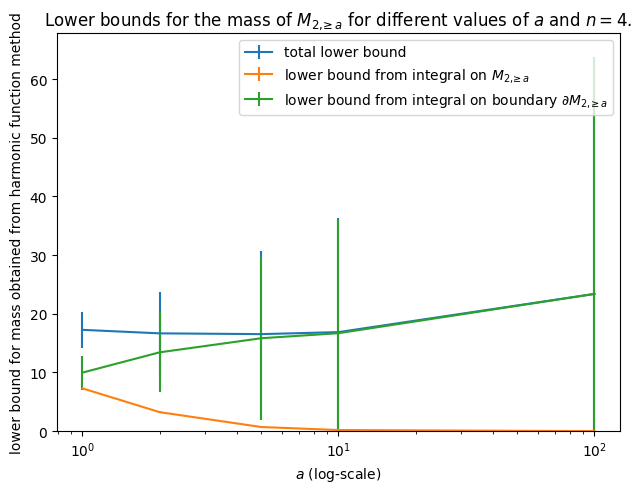

In [ ]:
plt.errorbar(a_values,total_lower_bounds,yerr=total_errors,label=f"total lower bound")
plt.errorbar(a_values,lower_bounds_M,yerr=errors_M,label=f"lower bound from integral on $ M_{{{m_value},\!\!\geq a}}$")
plt.errorbar(a_values,lower_bounds_boundary,yerr=errors_boundary,label=f"lower bound from integral on boundary $\partial M_{{{m_value},\!\!\geq a}}$")
plt.xscale('log')
plt.gca().set_ylim(bottom=0)
plt.xlabel("$a$ (log-scale)")
plt.ylabel("lower bound for mass obtained from harmonic function method")
plt.legend()
plt.tight_layout()
plt.title(f"Lower bounds for the mass of $M_{{{m_value},\!\!\geq a}}$ for different values of $a$ and $n={dim}$.")
plt.savefig("../figures/lower_bounds_for_different_values_of_a",bbox_inches='tight')

## Plotting the harmonic coordinates

### Plotting Utilities

Matplotlib does not come with a method of plotting implicit surfaces. The following approach is from [answers to this Stack Overflow question](https://stackoverflow.com/questions/4680525/plotting-implicit-equations-in-3d).

```python
# https://stackoverflow.com/a/4687582
def plot_implicit_using_contours(ax,fn,level_set_value=0, bbox=((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)),resolution=50,samples=30):
    """ Create a plot of a 2d implicite surface fn(x,y,z)=level_set_value using contours

    Args:
        ax (matplotlib.axes)
        fn (function): Function describing the implicit surface
        level_set_value (int, optional): Which level set of fn to consider. Defaults to 0.
        bbox (tuple, optional): x,y,and z limits of plotted interval. Defaults to ((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)).
        resolution (int, optional): Defaults to 50.
        samples (int, optional): Number of slices to take
    """
    xmin, xmax = bbox[0]
    ymin, ymax = bbox[1]
    zmin,zmax = bbox[2]
    
    xl = np.linspace(xmin, xmax, resolution)
    yl = np.linspace(ymin,ymax,resolution)
    zl = np.linspace(zmin, zmax, samples)
    A1, A2 = np.meshgrid(xl,xl)

    for z in zl: # plot contours in the XY plane
        X,Y = A1,A2
        Z = fn(X,Y,z)-level_set_value
        cset = ax.contour(X, Y, Z+z-level_set_value, [z], zdir='z')
        # [z] defines the only level to plot for this contour for this value of z

    for y in zl: # plot contours in the XZ plane
        X,Z = A1,A2
        Y = fn(X,y,Z)-level_set_value
        cset = ax.contour(X, Y+y, Z, [y], zdir='y')

    for x in zl: # plot contours in the YZ plane
        Y,Z = A1,A2
        X = fn(x,Y,Z)-level_set_value
        cset = ax.contour(X+x, Y, Z, [x], zdir='x')

    # must set plot limits because the contour will likely extend
    # way beyond the displayed level.  Otherwise matplotlib extends the plot limits
    # to encompass all values in the contour.
    ax.set_zlim3d(zmin,zmax)
    ax.set_xlim3d(xmin,xmax)
    ax.set_ylim3d(ymin,ymax)

def plot_implicit_using_marching_cubes(ax,fn,level_set_value=0,bbox=((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)),resolution=50):
    """ Create a plot of a 2d implicit surface fn(x,y,z)=level_set_value using marching cubes

    Args:
        ax (matplotlib.axes)
        fn (function): Function describing the implicit surface
        level_set_value (int, optional): Which level set of fn to consider. Defaults to 0.
        bbox (tuple, optional): x,y,and z limits of plotted interval. Defaults to ((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)).
        resolution (int, optional): Defaults to 50.
    """
    xmin, xmax = bbox[0]
    ymin, ymax = bbox[1]
    zmin,zmax = bbox[2]
    
    xl = np.linspace(xmin,xmax, resolution)
    yl = np.linspace(ymin,ymax, resolution)
    zl = np.linspace(zmin,zmax, resolution)
    X, Y, Z = np.meshgrid(xl, yl, zl)
    F=fn(X,Y,Z)


    verts, faces, normals, values = measure.marching_cubes(F, level_set_value, spacing=[np.diff(xl)[0],np.diff(yl)[0],np.diff(zl)[0]])
    # need to correct vertex coordinates as they are expressed in Voxel coordinates
    verts += (xmin,ymin,zmin)
    
    ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, 
                    verts[:, 2], # color
                    cmap='magma',vmin=zmin,vmax=zmax)
    
    ax.set_zlim3d(zmin,zmax)
    ax.set_xlim3d(xmin,xmax)
    ax.set_ylim3d(ymin,ymax)
    return verts, faces
```

```python
def plot_coordinate_level_sets(coordinate,level_set_values=(0),m_value=1,a_value=0,bbox=((-2.5,2.5),(-2.5,2.5),(-2.5,2.5)),resolution=50):
  fn = sympy.lambdify([x1,x2,x1],(coordinate()).subs(((m,m_value),(a,a_value))))

  n_plots = len(level_set_values)
  n_cols = min(2,n_plots)
  n_rows = (n_plots+1)//2

  fig = plt.figure(figsize=(10,n_rows*4+1))
  fig.suptitle(f"Level sets of ${sympy.latex(coordinate.symbol)}$ on $M_{{{m_value},\!\!\geq {a_value}}}$",fontsize=20,y=0,va="top")

  axes = fig.subplots(ncols=n_cols,nrows=n_rows,subplot_kw=dict(projection='3d'),squeeze=False)

  if n_plots<n_rows*2:
    fig.delaxes(axes[n_rows-1,n_cols-1]) # delete last axis if unneccessary

  for index, level_set_value in enumerate(level_set_values):
    ax = axes.flatten()[index]
    ax.set_title(f"${sympy.latex(coordinate.symbol)}={level_set_value:.2f}$",fontsize=16,pad=0)
    ax.locator_params(nbins=4)
    
    plot_implicit_using_marching_cubes(ax,fn,level_set_value,bbox=bbox,resolution=resolution)
    ax.set_aspect('equal')
  fig.tight_layout(h_pad=5)
  return fig
```

### Plots for $M_{m,+}=M_{m,\geq 0}$

```python
fig=plot_coordinate_level_sets(u1,[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7],bbox=[(-1.5,1.5),(-1.5,1.5),(0,1.1)])
fig.savefig("../figures/level_sets_u1_unmodified",bbox_inches='tight')
````

```python
plot_coordinate_level_sets(u2,[-0.75,-0.5,-0.25,0,0.25,0.5,0.75],bbox=[(-1.1,1.1),(-1.1,1.1),(0,1.1)])
plt.savefig("../figures/level_sets_u2_unmodified",bbox_inches="tight")
```

### Plots for $M_{m,\!\!\geq a}$. We can symbolically check that the boundary $x_3=a$ is actually a level set. Numerically this level set is not quite correctly computed due to rounding errors. 

```python
for a_value in [0.1,0.3]:
  fig=plot_coordinate_level_sets(u1_modified,np.array([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7])+a_value,a_value=a_value,bbox=[(-1.1,1.1),(-1.1,1.1),(0,1.5)],resolution=100)
  fig.savefig(f'../figures/level_sets_u1_modified_with_a_{a_value}.png',bbox_inches='tight')
```